## Preprocess data

In [1]:
from datasets import load_dataset, DatasetDict
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM, get_linear_schedule_with_warmup
from torch.optim import AdamW
import torch
import pytorch_lightning as pl
from tqdm import tnrange
from collections import Counter


# from evaluate import load
# import bert_score
from transformers import logging
logging.set_verbosity_error()
import matplotlib.pyplot as plt
# import bert_score


from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor


import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
dataset = load_dataset("xsum")

use_percent_train = 15
dataset_train = load_dataset("xsum", split=f"train[:{use_percent_train}%]")
dataset_val = load_dataset("xsum", split=f"validation[:{2*use_percent_train}%]")
dataset_test = load_dataset("xsum", split=f"test[:{2*use_percent_train}%]")
dataset = DatasetDict({'train': dataset_train, 'validation': dataset_val, 'test': dataset_test})

print(dataset)

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

Dataset xsum downloaded and prepared to /root/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 30607
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 3400
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 3400
    })
})


In [3]:
example = dataset['train'][0]

print("text:", example["document"])
print("Summary:", example["summary"])
print("id:", example["id"])

text: The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.
Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.
Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct.
Many businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.
First Minister Nicola Sturgeon visited the area to inspect the damage.
The waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.
Jeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.
However, she said more preventative work could have been carried out to ensure the retaining wall did not fail.
"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally appreciate that - but it

In [4]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")

prefix = "summarize: "
max_input_length = 600
max_target_length = 200

def preprocessor(examples, prefix='summarize:', max_input_length=512, max_target_length=128):
  # encode the code-docstring pairs
  texts = examples['document']
  summaries = examples['summary']
  
  inputs = [prefix + text for text in texts]
  model_inputs = tokenizer(inputs, max_length=max_input_length, padding="max_length", truncation=True)

  # encode the summaries
  labels = tokenizer(summaries, max_length=max_target_length, padding="max_length", truncation=True).input_ids

  # important: we need to replace the index of the padding tokens by -100
  # such that they are not taken into account by the CrossEntropyLoss
  labels_with_ignore_index = []
  for labels_example in labels:
    labels_example = [label if label != 0 else -100 for label in labels_example]
    labels_with_ignore_index.append(labels_example)
  
  model_inputs["labels"] = labels_with_ignore_index

  return model_inputs

In [5]:
dataset = dataset.map(preprocessor, batched=True)
print(dataset)

  0%|          | 0/31 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 30607
    })
    validation: Dataset({
        features: ['document', 'summary', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3400
    })
    test: Dataset({
        features: ['document', 'summary', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3400
    })
})


In [6]:
dataset.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 30607
    })
    validation: Dataset({
        features: ['document', 'summary', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3400
    })
    test: Dataset({
        features: ['document', 'summary', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3400
    })
})


In [7]:
num_workers = os.cpu_count()
train_dataloader = DataLoader(dataset['train'], shuffle=True, batch_size=8, num_workers=num_workers)
valid_dataloader = DataLoader(dataset['validation'], batch_size=4, num_workers=num_workers)
test_dataloader = DataLoader(dataset['test'], batch_size=4, num_workers=num_workers)

In [8]:
batch = next(iter(train_dataloader))
print(batch.keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [9]:
tokenizer.decode(batch['input_ids'][0])

'summarize:The Tories claim 94% of working households are better off under the tax and benefit changes coming into effect. Labour\'s Ed Balls claimed average families were £1,100 a year worse off since 2010, including Monday\'s changes. Both parties say their rivals have secret plans to raise taxes if they win the general election. The Lib Dems, meanwhile, are angry with the Conservatives for claiming credit for an increase in the personal income tax allowance, which they say they had to force Tory ministers to accept. The personal allowance - the amount someone can earn before they are taxed - has gone up from £10,000 to £10,600. The Tories and Lib Dems have both said they want it to go up to £12,500 by 2020, but senior Lib Dem David Laws said his party would implement this "far faster". In other news: Shadow Chancellor Ed Balls, speaking in Leeds, said Britain could not afford five more years of the Tories. "Families are £1,100 a year worse off on average - that is the true cost of a

In [10]:
labels = batch['labels'][0]
tokenizer.decode([label for label in labels if label != -100])

'The official start of the new tax year has sparked a fresh battle between Labour and the Conservatives over their respective economic plans.</s>'

## Fine-tune using PyTorch Lightning


In [11]:
class T5(pl.LightningModule):
    def __init__(self, lr=5e-5, num_train_epochs=15, warmup_steps=1000):
        super().__init__()
        self.model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")
        self.train_losses=[]
        self.validation_losses=[]
        self.config=self.model.config

        self.train_losses_epoch=[]
        self.validation_losses_epoch=[]

        self.save_hyperparameters()

    def forward(self, input_ids, attention_mask, labels=None):     
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        return outputs
    
    def common_step(self, batch, batch_idx):
        outputs = self(**batch)
        loss = outputs.loss

        return loss
      
    def training_step(self, batch, batch_idx):
        loss = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        self.train_losses.append(loss)
        

        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss, on_epoch=True)
        self.validation_losses.append(loss)
        
            
        return loss

    
        return loss
    def on_train_epoch_end(self):
        # Calculate average loss for the epoch and append to the list
        avg_train_loss = sum(self.train_losses)/ len(self.train_losses)
        self.train_losses_epoch.append(avg_train_loss.item())

        # Reset epoch loss accumulator
        self.train_losses = []

    def on_validation_epoch_end(self):
        # Calculate average loss for the epoch and append to the list
        avg_val_loss = sum(self.validation_losses) / len(self.validation_losses)
        self.validation_losses_epoch.append(avg_val_loss.item())

        # Reset epoch loss accumulator
        self.validation_losses = []

    

        # Reset epoch loss accumulator
        self.test_losses = []
    def configure_optimizers(self):
        # create optimizer
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr)
        # create learning rate scheduler
        num_train_optimization_steps = self.hparams.num_train_epochs * len(train_dataloader)
        lr_scheduler = {'scheduler': get_linear_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=self.hparams.warmup_steps,
                                                    num_training_steps=num_train_optimization_steps),
                        'name': 'learning_rate',
                        'interval':'step',
                        'frequency': 1}
        
        return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}
    
    def generate(self, input_ids, max_new_tokens=100, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
        input_ids=input_ids.clone().detach().reshape((1,-1)).to(device)
        return self.model.generate(input_ids, max_new_tokens=max_new_tokens)
    
    def push_to_hub(self, model_name, organization):
        # Save the model
        self.model.push_to_hub(model_name, organization)

        
    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return valid_dataloader

    def test_dataloader(self):
        return test_dataloader

In [12]:
# Hyperparameters
lr = 5e-5
num_train_epochs = 10
warmup_steps = 1000
patience = 2
max_epochs = 10

# for early stopping, see https://pytorch-lightning.readthedocs.io/en/1.0.0/early_stopping.html?highlight=early%20stopping
early_stop_callback = EarlyStopping(
    monitor='validation_loss',
    patience=patience,
    strict=False,
    verbose=False,
    mode='min'
)
lr_monitor = LearningRateMonitor(logging_interval='step')
checkpoint_callback = ModelCheckpoint(dirpath='./', monitor='validation_loss', mode='min', save_top_k = 1)

accelerator = "gpu" if torch.cuda.is_available() else "cpu"
trainer = Trainer(accelerator=accelerator, 
                  callbacks=[early_stop_callback, lr_monitor, checkpoint_callback], max_epochs=max_epochs)

model = T5(lr=lr, num_train_epochs=num_train_epochs, warmup_steps=warmup_steps)
trainer.fit(model)
tokenizer.save_pretrained("./")
checkpoint_path = checkpoint_callback.best_model_path

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /kaggle/working exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [13]:
train_losses=model.train_losses_epoch
validation_losses=model.validation_losses_epoch


In [14]:
print('Loss on validation set before fine tuning: ', validation_losses[0])

Loss on validation set before fine tuning:  3.6617536544799805


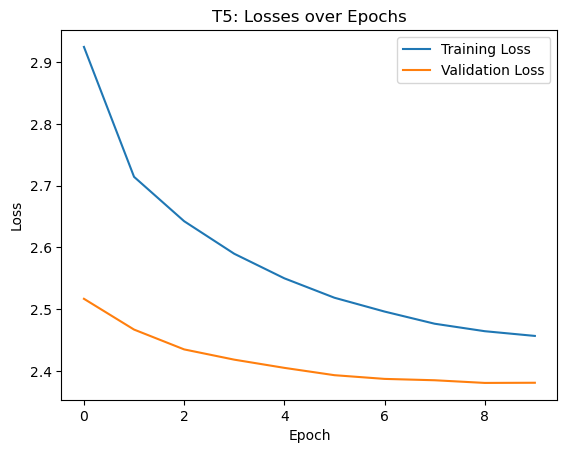

In [15]:

# Plotting the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses[1:], label='Validation Loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('T5: Losses over Epochs')

# Adding legend
plt.legend()

plt.savefig('losses_plot.png')
# Displaying the plot
plt.show()

## Inference

In [91]:
data_id = 9
test_dataset = dataset['test']
test_document = test_dataset['document'][data_id]
test_input_ids = test_dataset[data_id]['input_ids']
test_gt_summary = test_dataset['summary'][data_id]
test_attention_mask = test_dataset[data_id]['attention_mask']

In [92]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer_save_directory="./"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_save_directory)
checkpoint_path = './epoch=8-step=34434.ckpt'
new_model = T5.load_from_checkpoint(checkpoint_path).to(device)
new_model.eval()


In [93]:
print("Input document:")
print(test_document)

Input document:
"I'm really looking forward to it - the home of Scottish football," said Rodgers ahead of his maiden visit.
"I hear the pitch is good, a nice big pitch suits the speed in our team and our intensity.
"The technical area goes right out to the end of the pitch, but you might need a taxi to get back to your staff."
This will be Rodgers' second taste of the Old Firm derby and his experience of the fixture got off to a great start with a 5-1 league victory at Celtic Park last month.
"It was a brilliant performance by the players in every aspect," he recalled. "Obviously this one is on a neutral ground, but we'll be looking to have a similar performance.
"We'll be prepared and focused. We know it's going to be a tough game. We anticipated that the last time."
Rodgers is also aware Celtic's visit to Hampden last season in the Scottish Cup semi-final against Rangers ended in defeat.
"The last experience there wasn't so good for Celtic," he said. "But it's a different team with a

In [94]:
print("Ground truth summary:")
print(test_gt_summary)

Ground truth summary:
Manager Brendan Rodgers is sure Celtic can exploit the wide open spaces of Hampden when they meet Rangers in Sunday's League Cup semi-final.


In [95]:
output_ids = new_model.generate(test_input_ids.reshape((1,-1)))
generated_summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)

In [96]:
print("Generated summary:")
print(generated_summary)

Generated summary:
Celtic manager David Rodgers says he is looking forward to the Scottish Cup semi-finals with a "tough" start to the season.


### append the results

In [97]:
# def append_results(article, ground_truth_summary, generated_summary, filename="results.txt"):
#     # Initialize the result string in a readable format
#     result = f"\n\n---\n\nArticle:\n{article}\n\nGround Truth Summary:\n{ground_truth_summary}\n\nGenerated Summary:\n{generated_summary}\n\n---\n"
    
#     # Open the file in append mode, if the file does not exist it will be created
#     with open(filename, "a", encoding="utf-8") as file:
#         file.write(result)

#     print(f'Results have been appended successfully to {filename}')


# append_results(test_document, test_gt_summary, generated_summary)

Results have been appended successfully to results.txt


### Save the files

In [24]:
# import os
# import zipfile

# def zip_files(*file_names, zip_name="archive.zip"):
#     # Make sure all file names are strings and the files exist
#     for name in file_names:
#         if not isinstance(name, str) or not os.path.isfile(name):
#             raise ValueError(f"{name} is not a valid file name.")

#     # Create a new zip file (or overwrite an existing one)
#     with zipfile.ZipFile(zip_name, 'w') as zipf:
#         for name in file_names:
#             zipf.write(name)

#     print(f'Files have been zipped successfully into {zip_name}')

# zip_files("special_tokens_map.json", "spiece.model", "losses_plot.png", "tokenizer_config.json", "tokenizer.json")

Files have been zipped successfully into archive.zip


### Push to Huggingface

In [101]:
# from transformers import T5Config, T5ForConditionalGeneration

# model_file='./t5_model.bin'
# config_file='./t5_config.json'

# torch.save(model.state_dict(), model_file)
# model.config.to_json_file(config_file)

# config = T5Config.from_json_file(config_file)
# test_model = T5ForConditionalGeneration(config)
# state_dict = torch.load(model_file)
# new_state_dict = {key.replace("model.", ""): value for key, value in state_dict.items()}
# test_model.load_state_dict(new_state_dict)
# test_model.eval()

# from huggingface_hub import notebook_login
# notebook_login()
# test_model.push_to_hub("T5_summarizer", organization="ZinebSN")
# tokenizer.push_to_hub("T5_summarizer", organization="ZinebSN")

# tokenizer.save_pretrained("ZinebSN/T5_summarizer")

/opt/conda/lib/python3.10/site-packages/transformers/utils/hub.py:652: UserWarning: The `organization` argument is deprecated and will be removed in v5 of Transformers. Set your organization directly in the `repo_id` passed instead (`repo_id={organization}/{model_id}`).
  warnings.warn(


Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

('ZinebSN/T5_summarizer/tokenizer_config.json',
 'ZinebSN/T5_summarizer/special_tokens_map.json',
 'ZinebSN/T5_summarizer/spiece.model',
 'ZinebSN/T5_summarizer/added_tokens.json',
 'ZinebSN/T5_summarizer/tokenizer.json')